In [1021]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, FunctionTransformer

# Синтетические данные

In [1022]:
def generate_binary_dataset(n: int = 100,
                            dependency_type: str = 'lines',
                            noise: float = 0.25,
                            rnd: int = 42):
    X, y = (None, None)
    
    if dependency_type == 'lines':
        X, y = make_classification(n, n_features=2, n_informative=2, n_redundant=0, 
                                   n_classes=2, n_clusters_per_class=1, class_sep=2,
                                   random_state=rnd)
    elif dependency_type == 'moons':
        X, y = make_moons(n_samples=n, noise=noise, random_state=rnd)
    elif dependency_type == 'circles':
        X, y = make_circles(n_samples=n, 
                             noise=noise, 
                             factor=0.5,
                             random_state=rnd)
        
    X += np.random.randn(*X.shape) * noise 
    return X, y

def draw_bClassification_dataset(
        ax,
        X,
        y,
        colors: tuple = ('red', 'blue'),
        title: str = None,
        labels: tuple = None,
    ):
    ax.set_title(title, fontdict={'size': 14})
    
    g1_indices = np.where(y == 1)
    g2_indices = np.where(y == 0)
    
    labels = labels or ('Group 1', 'Group 2')
    ax.scatter(X[g1_indices].T[0], X[g1_indices].T[1], c=colors[0], label=labels[0])
    ax.scatter(X[g2_indices].T[0], X[g2_indices].T[1], c=colors[1], label=labels[1])
    ax.legend()

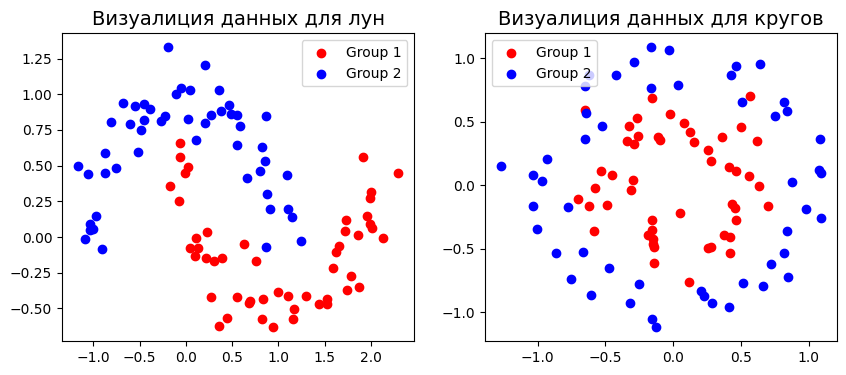

In [1023]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

moons_ds = generate_binary_dataset(dependency_type='moons', noise=0.1)
circles_ds = generate_binary_dataset(dependency_type='circles', noise=0.1)

draw_bClassification_dataset(ax[0], moons_ds[0], moons_ds[1], title='Визуалиция данных для лун')
draw_bClassification_dataset(ax[1], circles_ds[0], circles_ds[1], title='Визуалиция данных для кругов')

In [1024]:
# Utilities
def sigmoid(z):
        return 1 / (1 + np.e ** (-z))

def sigmoid_derivation(z):
    return sigmoid(z) - sigmoid(z) ** 2

def convert_to_polynom(X, degree: int = 2):
    """Raises every given features up to specified degrees, starting from second degree"""
    
    X = np.atleast_2d(X)
    out = X.copy()
    for degree in range(2, degree + 1):
        out = np.column_stack((out, X ** degree))
    
    return out

# Создаим класс для регрессии

class LogisticRegression():
    """Logistic regression classifier"""
    
    def __init__(self, 
                 weights=None,
                 learning_rate=0.25, 
                 l1_penalty=0.0,
                 l2_penalty=0.0,
                 threshold=0.5,
                 batch_size=1000, 
                 n_batches=None,
                 random_state=42):
        
        self.weights = weights
        self.learning_rate = learning_rate
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.threshold = threshold
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.random_state = random_state
        
    def _init_weights(self, n_features: int, rnd=42) -> np.array:
        """Init inital random weights"""
        
        np.random.seed(rnd)
        weights = np.random.randn(n_features)
        self.weights = np.atleast_2d(weights).T
        
        return self.weights

    def _sigmoid(self, z):
        """Plain sigmoid"""
        
        return 1 / (1 + np.e ** (-z))

    def _sigmoid_derivation(self, z):
        """Derivative of sigmoid function"""
        
        return self.sigmoid(z) - self.sigmoid(z) ** 2
    
    def loss(self, X, y_true):
        """Cross entropy loss function"""
        
        pass
    
    def loss_gradient(self, X, y_hat, y) -> np.array:
        """Gradient of loss function"""
        loss = 2 * np.dot(X.T, (y_hat - y)) / y.size
        
        return loss
    
    def _update_weights(self, delta):
        """Updates weights including regulization"""
        
        l2_ = self.l2_penalty * np.sum(self.weights[1:])
        l1_ = np.sign(self.weights) * self.l1_penalty
        delta = delta + l1_ + l2_
        self.weights -= self.learning_rate * delta
    
    def predict(self, X) -> int:
        """Predict dataset classification probability"""
        
        X = np.atleast_2d(np.array(X))
        
        # Probably it should it be places somewhere else
        if X.shape[0] != self.weights.size:
            X = self._add_bias_to_x(X)
            assert X.shape[1] == self.weights.size
        
        arg = self.linear_combination(X, self.weights)
        return sigmoid(arg)
    
    def linear_combination(self, X, weights):
        return np.dot(X, weights)
    
    def _add_bias_to_x(self, X):
        """Adds bias to features instance"""
        X = np.atleast_2d(X)
        return np.column_stack((
            np.ones((X.shape[0], 1)),
            X
        ))
    
    def predict_class(self, x) -> int:
        """Predicts class of instance"""
        
        return int(self.predict(x) >= self.threshold)
        
    def fit(self, X, y_true, epsilon=1e-2, epochs=None):
        """Model fitting algorithm"""
        
        y_true = np.atleast_2d(y_true).T
        epochs = epochs or 0
        if self.weights is None:
            self._init_weights(X.shape[1] + 1) # + 1 adds bias
        
        while True:
            epochs -= 1
            
            y_hat = self.predict(X)
            loss_gradient = self.loss_gradient(self._add_bias_to_x(X), y_hat=y_hat, y=y_true)
            self._update_weights(loss_gradient)
            
            if loss_gradient.sum() <= epsilon:
                break
            if epochs == 0:
                break
    
    def _metrics_data(self, y_hat, y):        
        tp = np.where((y_hat == 1) & (y == 1))
        fn = np.where((y_hat == 0) & (y == 1))
        fp = np.where((y_hat == 1) & (y == 0))
        tn = np.where((y_hat == 0) & (y == 0))
        
        return tp, fn, fp, tn
            
    def prediction_report(self, X, y):
        """Metrics report"""
        y_hat = np.array([self.predict_class(x) for x in X])
        tp, fn, fp, tn = self._metrics_data(y_hat, y)
        
        n_tp, n_fn, n_fp, n_tn = len(y[tp]), len(y[fn]), len(y[fp]), len(y[tn])
        metrics_matrix = pd.DataFrame(data={
            'y=1': [n_tp, n_fn],
            'y=0': [n_fp, n_tn]
        }, index=['y_hat=1', 'y_hat=0'])
        
        comparison_matrix = pd.DataFrame(data={
            'predictions': y_hat,
            'y_true': y
            }
        )
        
        logistic_regression_metrics = pd.DataFrame(data={
            'accuracy': (n_tp + n_tn) / np.max([1, (n_tp + n_tn + n_fp + n_fn)]),
            'precion': n_tp / np.max([1, (n_tp + n_fp)]),
            'recall': n_tp / np.max([1, (n_tp + n_fn)]),
            'f1_score': n_tp / np.max([1, (n_tp + 0.5 * (n_fp+n_fn))])
        }, index=[0])
        
        return metrics_matrix, comparison_matrix, logistic_regression_metrics
    
    def draw_classification(self, ax, X, y, poly=False, order=2, title=''):
        y_hat = np.array([self.predict_class(x) for x in X])
        tp, fn, fp, tn = self._metrics_data(y_hat, y)
        colors = ['red', 'blue', 'orange', 'green']
        labels = ['group 1 hit', 'group 2 hit', 'group 1 miss', 'group 2 miss']
        
        ax.set_title(title, fontdict={'size': 8})
        
        ax.scatter(X[tp].T[0], X[tp].T[1], c=colors[0], label=labels[0])
        ax.scatter(X[tn].T[0], X[tn].T[1], c=colors[1], label=labels[1])
        ax.scatter(X[fn].T[0], X[fn].T[1], c=colors[2], label=labels[2])
        ax.scatter(X[fp].T[0], X[fp].T[1], c=colors[3], label=labels[3])
        
        # Copypast
        h =  (X[:, 0].max() - X[:, 0].min()) / 50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max() + 0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict(convert_to_polynom(np.c_[xx.ravel(), yy.ravel()], order)) - 0.5
        else:
            Z = self.predict(np.c_[xx.ravel(), yy.ravel()]) - 0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        # Copypast
        
        ax.legend()

In [1025]:
X_train, X_test, y_train, y_test = train_test_split(moons_ds[0], 
                                                    moons_ds[1], 
                                                    test_size=0.3, 
                                                    random_state=42)
log_regr = LogisticRegression(learning_rate=0.25)
log_regr.fit(X_train, y_true=y_train, epochs=300)

train_report = log_regr.prediction_report(X_train, y_train)
test_report = log_regr.prediction_report(X_test, y_test)

print('Метрики для тренировачных данных: ')
display(train_report[-1])
print('Метрики для тестовы данных: ')
display(test_report[-1])

# Выводы в принципе линейная регрессия неплохо справляется с лунами, но можно лучше

Метрики для тренировачных данных: 


,accuracy,precion,recall,f1_score
0,0.842857,0.871795,0.85,0.860759


Метрики для тестовы данных: 


,accuracy,precion,recall,f1_score
0,0.9,0.769231,1.0,0.869565


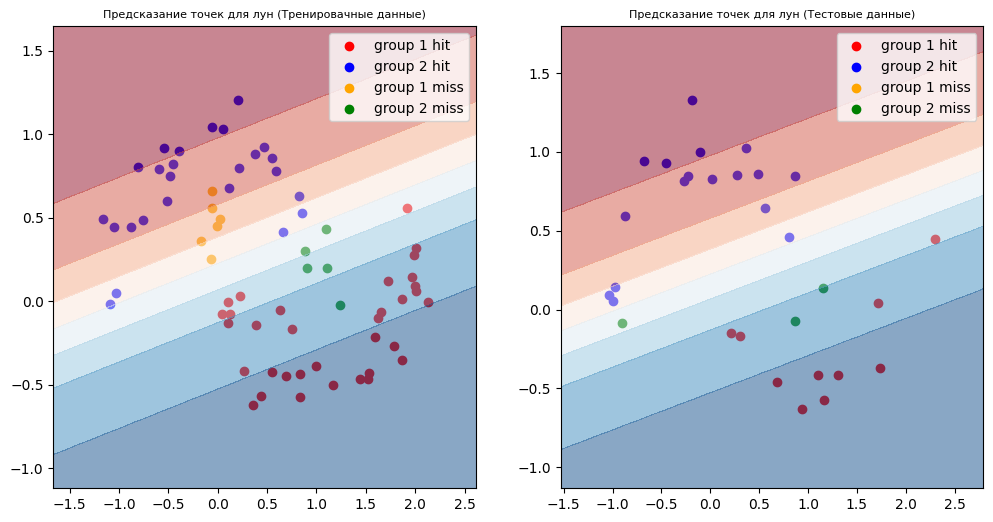

In [1026]:
# Отрисуем данные и функцию принятия решения

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
log_regr.draw_classification(ax[0], X_train, y_train, title='Предсказание точек для лун (Тренировачные данные)')
log_regr.draw_classification(ax[1], X_test, y_test, title='Предсказание точек для лун (Тестовые данные)')


## Теперь посмотрим на набор данных с кругами

In [1027]:
X_train, X_test, y_train, y_test = train_test_split(circles_ds[0], 
                                                    circles_ds[1], 
                                                    test_size=0.3, random_state=None)
log_regr = LogisticRegression(learning_rate=0.25, l1_penalty=0.125, l2_penalty=0.052) # С такими гиперпараметрами получились лучшие метрики
log_regr.fit(X_train, y_true=y_train, epochs=500)

train_report = log_regr.prediction_report(X_train, y_train)
test_report = log_regr.prediction_report(X_test, y_test)

print('Метрики для тренировачных данных: ')
display(train_report[0], train_report[-1])
print('Метрики для тестовы данных: ')
display(test_report[0], train_report[-1])

# Выводы с данным набором линейная функция уже очень плохо справляется

Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,32,19
y_hat=0,6,13


,accuracy,precion,recall,f1_score
0,0.642857,0.627451,0.842105,0.719101


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,11,13
y_hat=0,1,5


,accuracy,precion,recall,f1_score
0,0.642857,0.627451,0.842105,0.719101


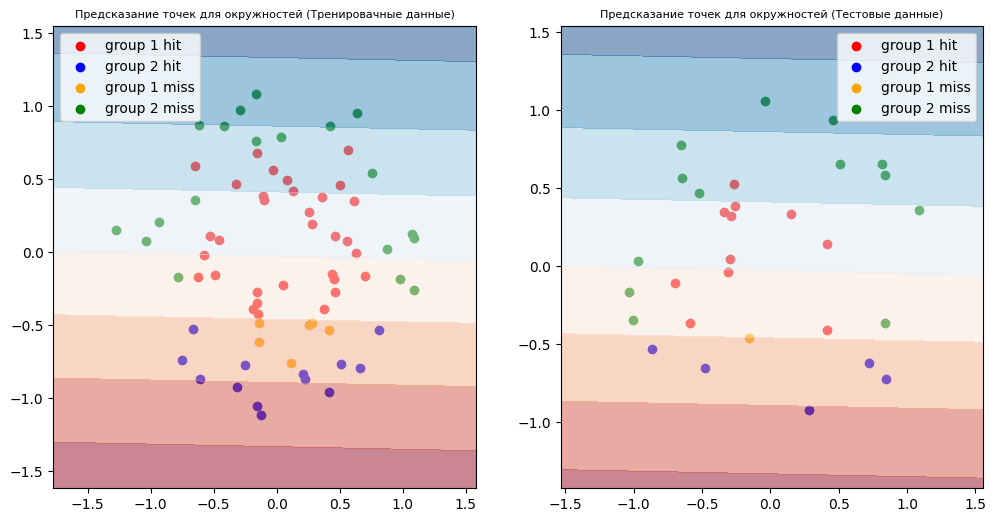

In [1028]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
log_regr.draw_classification(ax[0], X_train, y_train, title='Предсказание точек для окружностей (Тренировачные данные)')
log_regr.draw_classification(ax[1], X_test, y_test, title='Предсказание точек для окружностей (Тестовые данные)')

# Видно что модель пытается подобрать минимальную ошибку, поэтому модель сильно зависит от шумов на таком небольшом датасете

### Усложним входные данные

In [1029]:
moons_ds_X, moons_ds_y = moons_ds
moons_ds_X_2 = convert_to_polynom(moons_ds_X, degree=2)
moons_ds_X_3 = convert_to_polynom(moons_ds_X, degree=3)
moons_ds_X_4 = convert_to_polynom(moons_ds_X, degree=4)

circles_ds_X, circles_ds_y = circles_ds
circles_ds_X_2 = convert_to_polynom(circles_ds_X, degree=2)

In [1030]:
def evaluate_polynomial_model(X, y, degree):
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    log_regr = LogisticRegression(learning_rate=0.25)
    log_regr.fit(X_train, y_true=y_train, epochs=300)

    train_report = log_regr.prediction_report(X_train, y_train)
    test_report = log_regr.prediction_report(X_test, y_test)

    print('Метрики для тренировачных данных: ')
    display(train_report[0], train_report[-1])
    print('Метрики для тестовы данных: ')
    display(test_report[0], test_report[-1])

    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    log_regr.draw_classification(ax[0], X_train, y_train, poly=True,
                                order=degree, title=f'{degree} степень (Тренировачные данные)')
    log_regr.draw_classification(ax[1], X_test, y_test, poly=True,
                                order=degree, title='{degree} степень (Тестовые данные)')

# Посмотрим какая степень полинома справляется лучше при одинаковых гиперпараметрах

Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,35,6
y_hat=0,5,24


,accuracy,precion,recall,f1_score
0,0.842857,0.853659,0.875,0.864198


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,10,4
y_hat=0,0,16


,accuracy,precion,recall,f1_score
0,0.866667,0.714286,1.0,0.833333


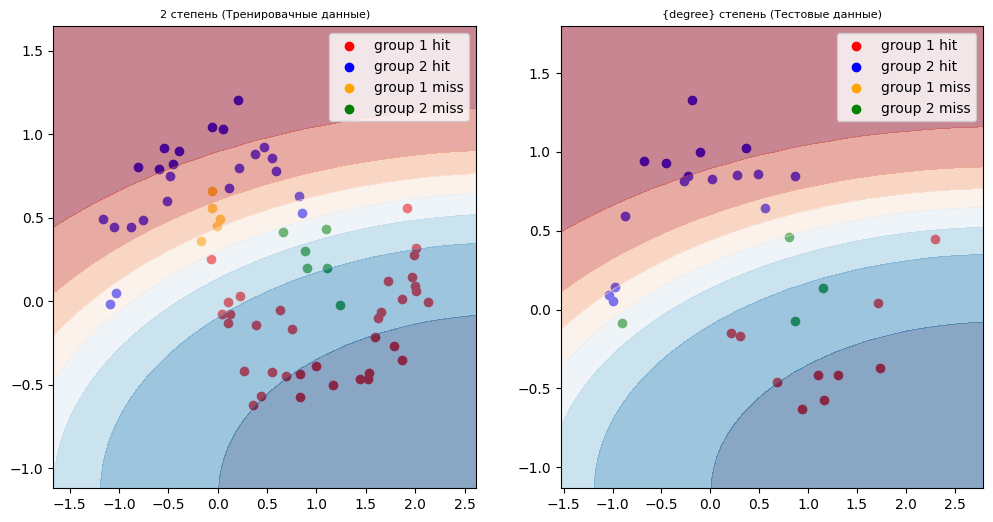

In [1031]:
evaluate_polynomial_model(moons_ds_X_2, moons_ds_y, degree=2)
# Уже лучше, точность сильно выросла

Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,38,1
y_hat=0,2,29


,accuracy,precion,recall,f1_score
0,0.957143,0.974359,0.95,0.962025


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,10,2
y_hat=0,0,18


,accuracy,precion,recall,f1_score
0,0.933333,0.833333,1.0,0.909091


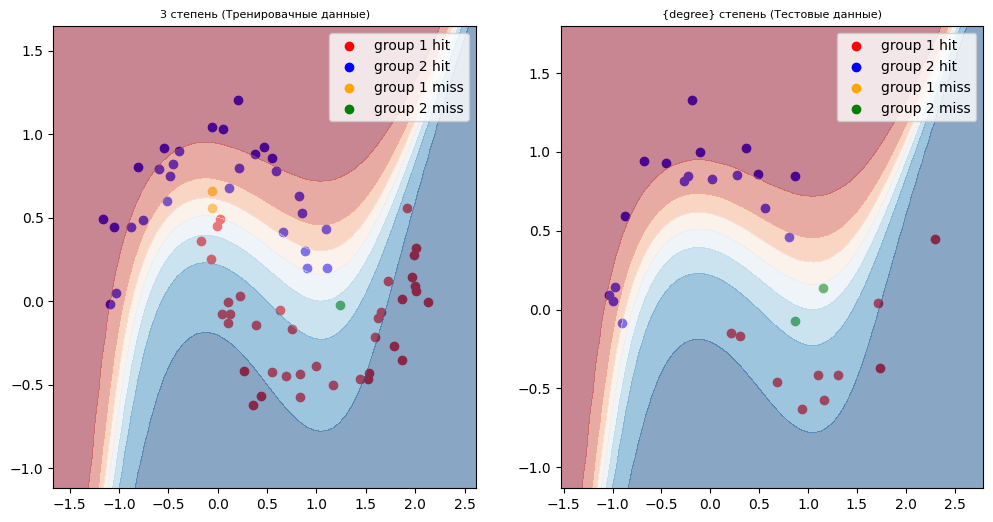

In [1032]:
evaluate_polynomial_model(moons_ds_X_3, moons_ds_y, degree=3)
# Ошибок меньше и метрики хорошие, проверим еще четвертую степень полинома

Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,38,1
y_hat=0,2,29


,accuracy,precion,recall,f1_score
0,0.957143,0.974359,0.95,0.962025


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,10,1
y_hat=0,0,19


,accuracy,precion,recall,f1_score
0,0.966667,0.909091,1.0,0.952381


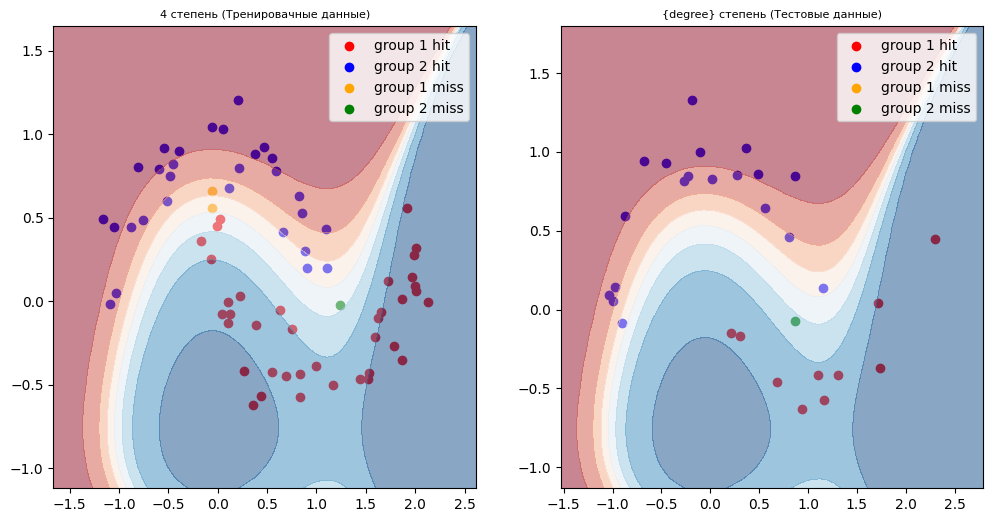

In [1033]:
evaluate_polynomial_model(moons_ds_X_4, moons_ds_y, degree=4)
# Метрики лучше не стали, делаем вывод - 3 степень лучше всего подходит

#### Теперь посмотрим на данные с окружностями

Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,38,3
y_hat=0,2,27


,accuracy,precion,recall,f1_score
0,0.928571,0.926829,0.95,0.938272


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,10,3
y_hat=0,0,17


,accuracy,precion,recall,f1_score
0,0.9,0.769231,1.0,0.869565


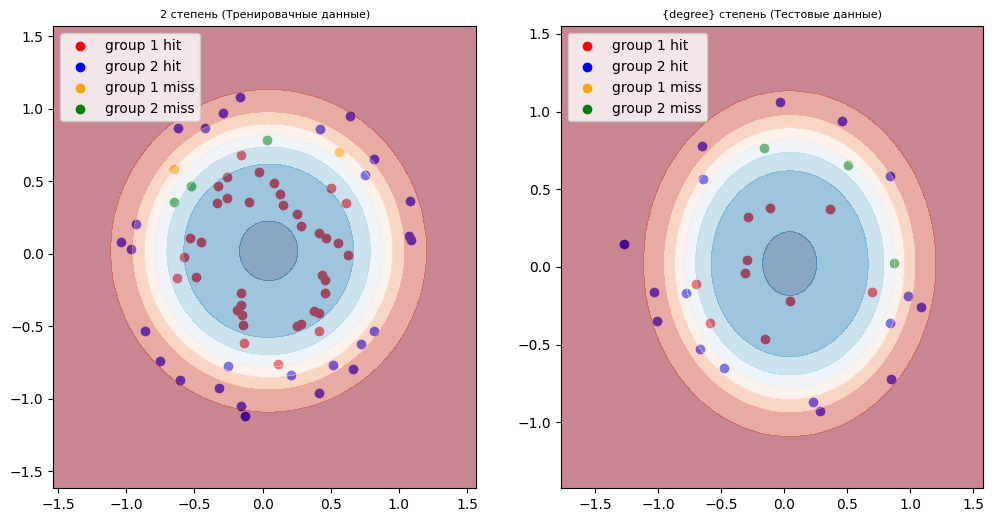

In [1034]:
evaluate_polynomial_model(circles_ds_X_2, circles_ds_y, degree=2)
# Делаем преждевременный вывод - 2 степень полинома отлично подходит для решения задачи

### Выводы 
Результаты на синтетике:
- Стало понятно как работает логистическая регрессия
- Вышло не наложать с размерностями матриц
- Подхватили тренд и получили неплохие метрики хоть и на относительно простых данных

Во что хочется углубиться:
- Еще раз пройтись по теории и понять как функция ошибок свелась к градиенту линейной регресии
- Совершенно не разобрался как рисуются контуры функции принятия решений
- По возможности попробовать мультиклассовую лог регрессию

# Набор данных для Cars Moldova

In [1035]:
TARGET = 'Transmission'

cars_df = pd.read_csv('datasets/cars_moldova_updated.csv', sep=',')
cars_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
1786,Volkswagen,Jetta,2014,Sedan,129000.0,2000.0,Petrol,Automatic,9999.0,7,18428.571429
17712,Audi,Q7,2007,Crossover,253000.0,3000.0,Diesel,Automatic,15000.0,14,18071.428571
29072,Opel,Frontera,1994,SUV,125000.0,2400.0,Metan/Propan,Manual,2000.0,27,4629.629630
16308,Dacia,Logan,2015,Sedan,195000.0,1200.0,Metan/Propan,Manual,2450.0,6,32500.000000
1655,Mitsubishi,Pajero Sport,2017,SUV,83000.0,2442.0,Diesel,Automatic,27000.0,4,20750.000000


In [1036]:
# Немного обработаем данные

grouping = cars_df.groupby(by=['Style', TARGET])[TARGET].count()

# Не уверен, что формировать такие признаки законно, но по идее они крайне статические
# Поэтому они не сильно зависят от конкретного набора данных. Так что можно было бы сформировать их по другому
cars_df['AutomaticManual_Quotient'] = np.nan

for style in cars_df['Style'].value_counts().index:
    style_transmission_section = grouping[style]
    style_automatic_manual_quotient = style_transmission_section['Automatic'] / style_transmission_section['Manual']
    mask = cars_df['Style'] == style
    cars_df['AutomaticManual_Quotient'][mask] = style_automatic_manual_quotient

# Округлим очень грубо, чтобы было меньше категорий
cars_df['Engine_volume_liters'] = np.ceil(cars_df['Engine_capacity(cm3)']/1000).astype(int)

fuel_type_encoder = OrdinalEncoder()
cars_df['Fuel_type'] = fuel_type_encoder.fit_transform(cars_df[['Fuel_type']]).astype(int) + 1

price_min_max_scaler = MinMaxScaler()
cars_df['Price(euro)'] = price_min_max_scaler.fit_transform(cars_df[['Price(euro)']]) # Возможно логарифмирование лучше

cars_df[TARGET] = cars_df[TARGET].map({'Automatic': 1, 'Manual': 0})

cars_df.sample(n=10)

/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_6714/2931095836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_df['AutomaticManual_Quotient'][mask] = style_automatic_manual_quotient


,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,AutomaticManual_Quotient,Engine_volume_liters
12981,Volkswagen,Passat,2008,Sedan,163000.0,1900.0,1,0,0.053096,13,12538.461538,1.157473,2
15536,Audi,Q3,2012,SUV,188000.0,2000.0,1,1,0.143287,9,20888.888889,2.990802,2
12979,Honda,Jazz,2007,Hatchback,123000.0,1400.0,5,1,0.022545,14,8785.714286,0.457798,2
3564,Audi,A4,2017,Sedan,68000.0,2000.0,5,1,0.203307,4,17000.000000,1.157473,2
77,Renault,Megane,2009,Universal,165000.0,1500.0,1,0,0.048086,12,13750.000000,0.346448,2
16051,Ford,Focus,2013,Universal,139000.0,1000.0,5,0,0.049599,8,17375.000000,0.346448,1
22565,Opel,Combo,2002,Minivan,225000.0,1700.0,1,0,0.028056,19,11842.105263,0.262854,2
2449,Volkswagen,Caddy,2007,Minivan,300000.0,1968.0,1,0,0.033066,14,21428.571429,0.262854,2
21960,Land Rover,Discovery,2012,SUV,273531.0,2993.0,1,1,0.148297,9,30392.333333,2.990802,3
15649,Jeep,Grand Cherokee,2006,SUV,190000.0,3000.0,1,1,0.068136,15,12666.666667,2.990802,3


In [1037]:

FEATURES = ['AutomaticManual_Quotient', 'Age', 'Price(euro)', 'Fuel_type', 'Engine_volume_liters']

def spin_model(X, y, degree = None, l1=0.5, l2=0.5, threshold=0.5):
    if degree:
        X = convert_to_polynom(X.values)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size=0.3, 
                                                        random_state=42)

    log_regr = LogisticRegression(l1_penalty=l1, l2_penalty=l2, threshold=threshold)
    log_regr.fit(X_train.values, y_train.values, epsilon=1e-3, epochs=300)

    train_report = log_regr.prediction_report(X_train.values, y_train.values)
    test_report = log_regr.prediction_report(X_test.values, y_test.values)

    print(f'Степень полинома данных {degree or 1}')
    print('Метрики для тренировачных данных: ')
    display(train_report[0], train_report[-1])
    print('Метрики для тестовы данных: ')
    display(test_report[0], test_report[-1])
    
    formula = [f'({np.round(coef[0], decimals=3)}) * {feature}' for coef, feature in zip(log_regr.weights[1:], FEATURES)]
    print('Model form:', ' + '.join(formula))
    

spin_model(cars_df[FEATURES], cars_df[TARGET], l1=0.7, l2=0.7, threshold=0.15) # Почему-то с таким порогом лучшие метрики

# Почти нет сонаправленных векторов
# С этим надо что-то придумывать

Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,7241,3641
y_hat=0,2871,8659


,accuracy,precion,recall,f1_score
0,0.709441,0.665411,0.71608,0.689816


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,3125,1577
y_hat=0,1296,3608


,accuracy,precion,recall,f1_score
0,0.700916,0.664611,0.706854,0.685082


Model form: (0.984) * AutomaticManual_Quotient + (-0.66) * Age + (1.842) * Price(euro) + (0.701) * Fuel_type + (0.778) * Engine_volume_liters


In [1038]:
### Попробуем логарифмировать стоимость авто

cars_df['Price(euro)'] = price_min_max_scaler.inverse_transform(cars_df[['Price(euro)']])

log_price_transformer = FunctionTransformer(np.log2, validate=True)
cars_df['Price(euro)'] = log_price_transformer.fit_transform(cars_df[['Price(euro)']])

In [1039]:
print('Без регуляризации: ')
spin_model(cars_df[FEATURES], cars_df[TARGET], l1=0, l2=0, threshold=0.5)
print('C регуляризацией: ')
spin_model(cars_df[FEATURES], cars_df[TARGET], l1=5e-3, l2=0.012, threshold=0.5)

# Нет особой разницы, более того модель как-то по странному выставляет в данном случае веса для признаков

Без регуляризации: 
Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,6748,3984
y_hat=0,3364,8316


,accuracy,precion,recall,f1_score
0,0.67214,0.628774,0.667326,0.647476


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,2916,1678
y_hat=0,1505,3507


,accuracy,precion,recall,f1_score
0,0.668645,0.634741,0.659579,0.646922


Model form: (-0.036) * AutomaticManual_Quotient + (-1.361) * Age + (1.272) * Price(euro) + (-0.346) * Fuel_type + (-0.251) * Engine_volume_liters
C регуляризацией: 
Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,6923,4175
y_hat=0,3189,8125


,accuracy,precion,recall,f1_score
0,0.671426,0.623806,0.684632,0.652805


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,2983,1761
y_hat=0,1438,3424


,accuracy,precion,recall,f1_score
0,0.666979,0.628794,0.674734,0.650955


Model form: (-0.016) * AutomaticManual_Quotient + (-1.343) * Age + (1.289) * Price(euro) + (-0.326) * Fuel_type + (-0.23) * Engine_volume_liters


# Добавим one hot encoding

In [1040]:
cars_df_copy = cars_df.copy()

cars_df_copy['Fuel_type'] = fuel_type_encoder.inverse_transform(cars_df_copy[['Fuel_type']] - 1)

dummies = pd.get_dummies(cars_df_copy[['Style', 'Fuel_type']])
cars_df_copy = pd.concat((cars_df_copy, dummies), axis=1)

FETURES_WITH_ONE_HOT = np.append(dummies.columns.values, ['AutomaticManual_Quotient', 'Engine_volume_liters', 'Price(euro)', 'Age'])

cars_df_copy['Price(euro)'] = price_min_max_scaler.fit_transform(cars_df_copy[['Price(euro)']]) # Хорошо себя показала - сделаем снова

cars_df_copy

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,...,Style_Roadster,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,0.588473,10,...,0,0,0,0,0,0,1,0,0,0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,0.604281,7,...,0,0,0,1,1,0,0,0,0,0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,0.561404,9,...,0,0,0,1,1,0,0,0,0,0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,0.486020,15,...,0,0,0,1,0,0,0,1,0,0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,0.460100,21,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32013,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,1,0.651978,5,...,0,0,1,0,0,0,0,0,1,0
32014,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,0,0.497383,19,...,0,0,0,0,0,0,0,1,0,0
32015,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,0,0.572095,6,...,0,0,0,1,1,0,0,0,0,0
32016,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,0,0.482047,15,...,0,0,0,0,1,0,0,0,0,0


In [1041]:
spin_model(cars_df_copy[FETURES_WITH_ONE_HOT], cars_df_copy[TARGET], l1=0.3, l2=0.3, threshold=0.5)
# Не стало лучше(

Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,4423,1505
y_hat=0,5689,10795


,accuracy,precion,recall,f1_score
0,0.679011,0.74612,0.437401,0.551496


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,1972,661
y_hat=0,2449,4524


,accuracy,precion,recall,f1_score
0,0.676244,0.748956,0.446053,0.559115


Model form: (0.195) * AutomaticManual_Quotient + (0.826) * Age + (1.706) * Price(euro) + (0.159) * Fuel_type + (0.226) * Engine_volume_liters


In [1042]:
# На последок попробуем вторую степень полинома
cars_df_copy = cars_df.copy()
cars_df_copy['Price(euro)'] = price_min_max_scaler.fit_transform(cars_df_copy[['Price(euro)']])

display(cars_df_copy.sample(10))

spin_model(cars_df_copy[FEATURES], cars_df_copy[TARGET], l1=0.7, l2=0.7, threshold=0.5)

# Неплохо но особого прироста нет

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,AutomaticManual_Quotient,Engine_volume_liters
31265,Nissan,Micra,2008,Hatchback,90000.0,1400.0,5,0,0.406418,13,6923.076923,0.457798,2
19137,Suzuki,Ignis,2005,Hatchback,230000.0,1400.0,4,0,0.418802,16,14375.000000,0.457798,2
17877,Rover,400 Series,1997,Sedan,205000.0,1600.0,5,0,0.370512,24,8541.666667,1.157473,2
30388,Dacia,Lodgy,2012,Minivan,205000.0,1500.0,1,0,0.547264,9,22777.777778,0.262854,2
8821,Vaz,2106,1993,Sedan,111111.0,1100.0,5,0,0.603337,28,3968.250000,1.157473,2
8943,BMW,4 series,2014,Coupe,150250.0,2000.0,5,1,0.728470,7,21464.285714,0.952218,2
14475,BMW,6 Series,2017,Sedan,59000.0,2973.0,5,1,0.831072,4,14750.000000,1.157473,3
8376,BMW,6 Series,2004,Cabriolet,100000.0,4500.0,5,1,0.644825,17,5882.352941,1.147541,5
18508,Mercedes,C Class,2012,Sedan,204256.0,2000.0,1,0,0.589508,9,22695.111111,1.157473,2
29086,Skoda,Fabia,2010,Universal,200000.0,1199.0,1,0,0.493684,11,18181.818182,0.346448,2


Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,6857,2962
y_hat=0,3255,9338


,accuracy,precion,recall,f1_score
0,0.722604,0.69834,0.678105,0.688074


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,2952,1270
y_hat=0,1469,3915


,accuracy,precion,recall,f1_score
0,0.714866,0.699195,0.667722,0.683096


Model form: (1.007) * AutomaticManual_Quotient + (-0.653) * Age + (1.873) * Price(euro) + (0.712) * Fuel_type + (0.797) * Engine_volume_liters


# Выводы
Самые значемые парметры для модели это:
- Возраст и Цена наиболее важные признаки для предсказания 
- Также объем двигателя взасимости от разных преобразований других столбцов по разному влияел где-то сильно где-то слабо, но всегда сонаправлено

Какие результаты:
- Получилось провести логистический анализ со средним результатом около 70% верных ответов
- Удалось применить разные преобразования данных
- Получилось увидеть как влияют изменения парамтеров регуляризации

Что хочется изучить:
- Как можно визуализариовать модели более чем от двух параметров
- Понять как улучшить показатели